# Trying to use Python for arch garch forecasting

In [3]:
### Imports and Settings 
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [4]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

# Correlogram Plot

In [11]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)


def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0



## Downloading LLOY banking data 

In [8]:
start = pd.Timestamp('2017-01-01')
end = pd.Timestamp('2020-12-31')

lloyData = web.DataReader('LLOY.L', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

lloyData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1012 entries, 2017-01-03 to 2020-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1012 non-null   float64
 1   Low        1012 non-null   float64
 2   Open       1012 non-null   float64
 3   Close      1012 non-null   float64
 4   Volume     1012 non-null   float64
 5   Adj Close  1012 non-null   float64
dtypes: float64(6)
memory usage: 55.3 KB


In [9]:
lloyData.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,65.000000,62.619999,62.619999,64.620003,199032680.0,49.659489
2017-01-04,65.230003,64.370003,65.010002,64.769997,149207475.0,49.774761
2017-01-05,64.930000,64.209000,64.580002,64.650002,134256032.0,49.682545
2017-01-06,66.389999,65.230003,65.470001,65.900002,209162621.0,50.643150
2017-01-09,66.400002,64.690002,65.800003,65.220001,186782487.0,50.120586



### Observe volatility clustering

Volatility clustering refers to the observation that "large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes.

    Volatility clustering is frequently observed in financial market data, and it poses a challenge for time series modeling.

with the S&P 500 daily price dataset we calculate daily returns as the percentage price changes, plot the results and observe its behavior over time.


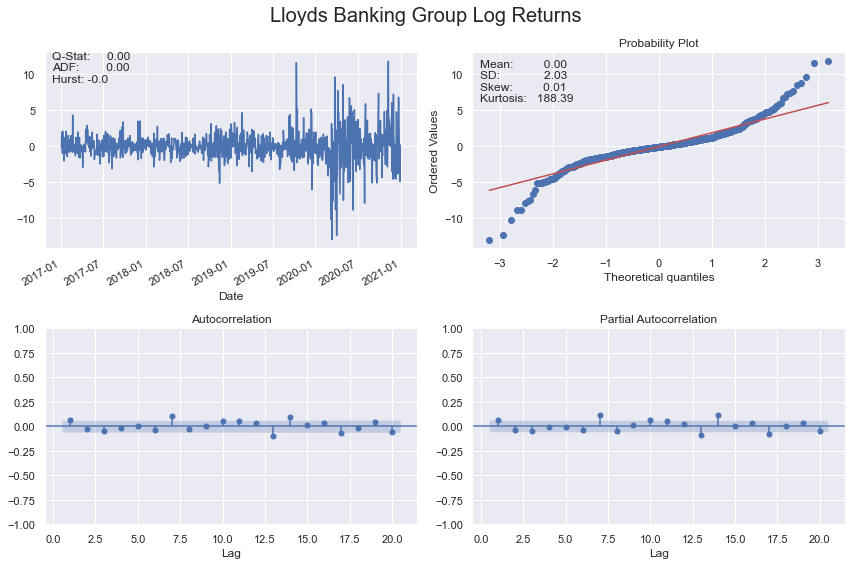

In [12]:
lloyData['Return'] = 100*(lloyData['Close'].pct_change())
lloyData['logrtn'] = np.log(lloyData['Close']).diff().mul(100)
lloyData = lloyData.dropna()
## Plot the stuff from before hmm
plot_correlogram(lloyData['logrtn'], lags = 20, title = "Lloyds Banking Group Log Returns")

## Trying Squared Returns

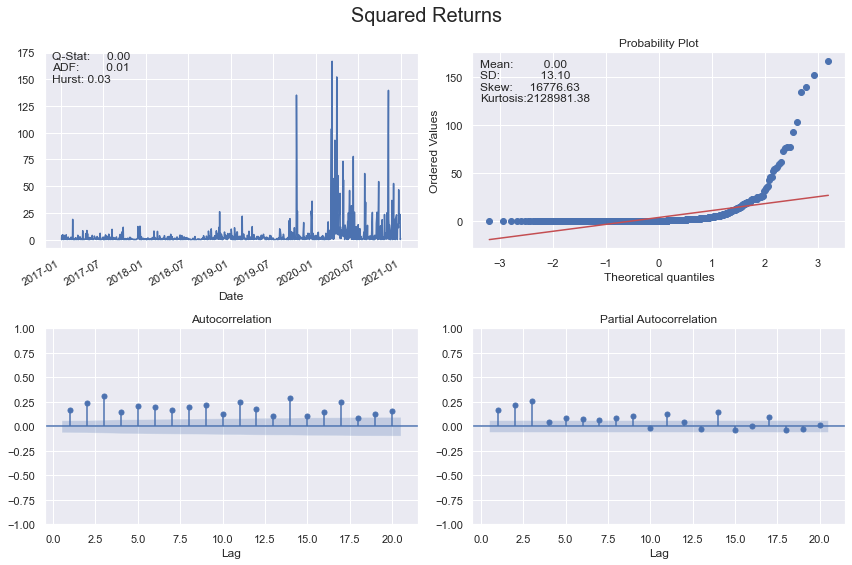

In [14]:
#This is the squared centered returns 
plot_correlogram(lloyData['logrtn'].sub(lloyData['logrtn'].mean()).pow(2), lags = 20, title = 'Squared Returns')

## Compute the volatiliyt of price returns in python (non conditional just sample)

In [15]:
# Calculate daily std of returns
std_daily = lloyData['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 2.03%

Monthly volatility: 9.29%

Annual volatility: 32.19%


# ARCH AND GARCH MODELS
### Simulating ARCH and GARCH series

In [24]:
#If beta = 0 this is just an ARCH Process as beta coeffficient is beta * sigma**2t-1 aka last variance
#Alpha is multiplied the error of the last outign
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance
    

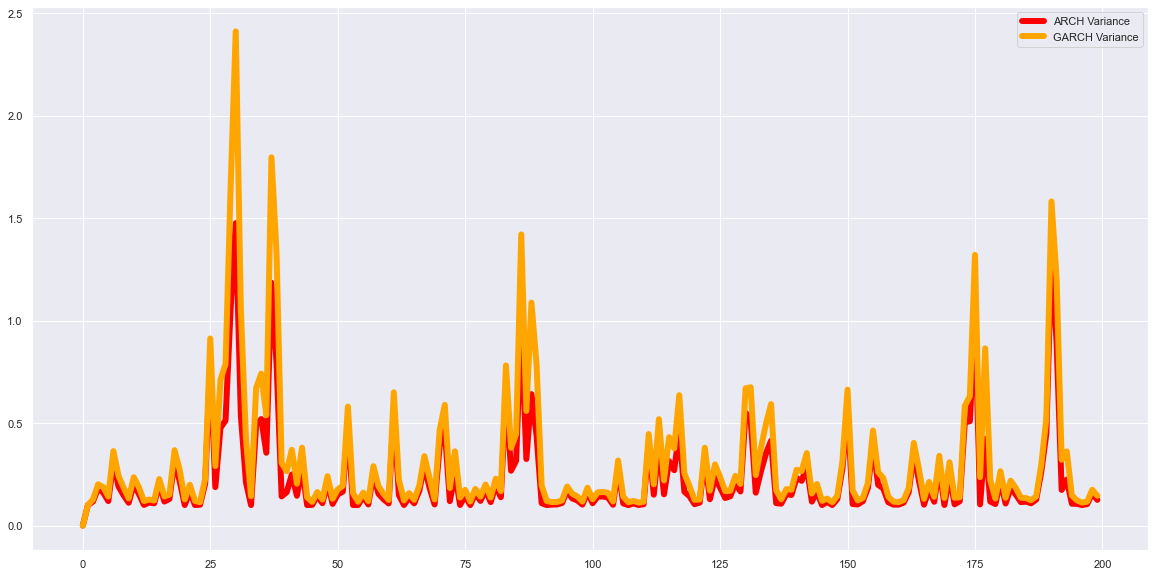

In [30]:
#Simulate an arch 1 series 
ar1Resid, ar1Var = simulate_GARCH(n = 200, 
                                 omega = 0.1, 
                                 alpha = 0.7)
#simulate a GARCH 1,1 series
g11Resid, g11Var = simulate_GARCH(n = 200, 
                                 omega = 0.1, 
                                 alpha = 0.7,
                                 beta = 0.1)
# Plot the ARCH variance
plt.figure(figsize=(20,10))
plt.plot(ar1Var, color = 'red', label = 'ARCH Variance', linewidth = 6)

# Plot the GARCH variance
plt.plot(g11Var, color = 'orange', label = 'GARCH Variance', linewidth = 6)
plt.legend()
plt.show()

Recall in GARCH(1,1), since β is the coefficient of lag-1 variance, if the α is fixed, the larger the β, the longer the duration of the impact. In other words, high or low volatility periods tend to persist. Pay attention to the plotted results and see whether we can verify the β impact.

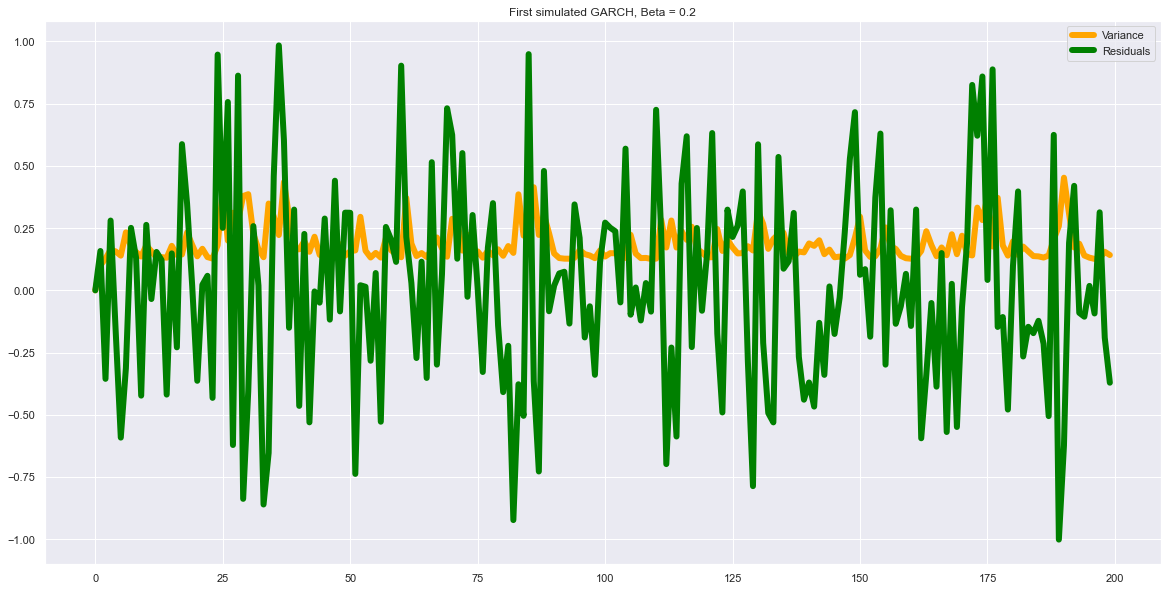

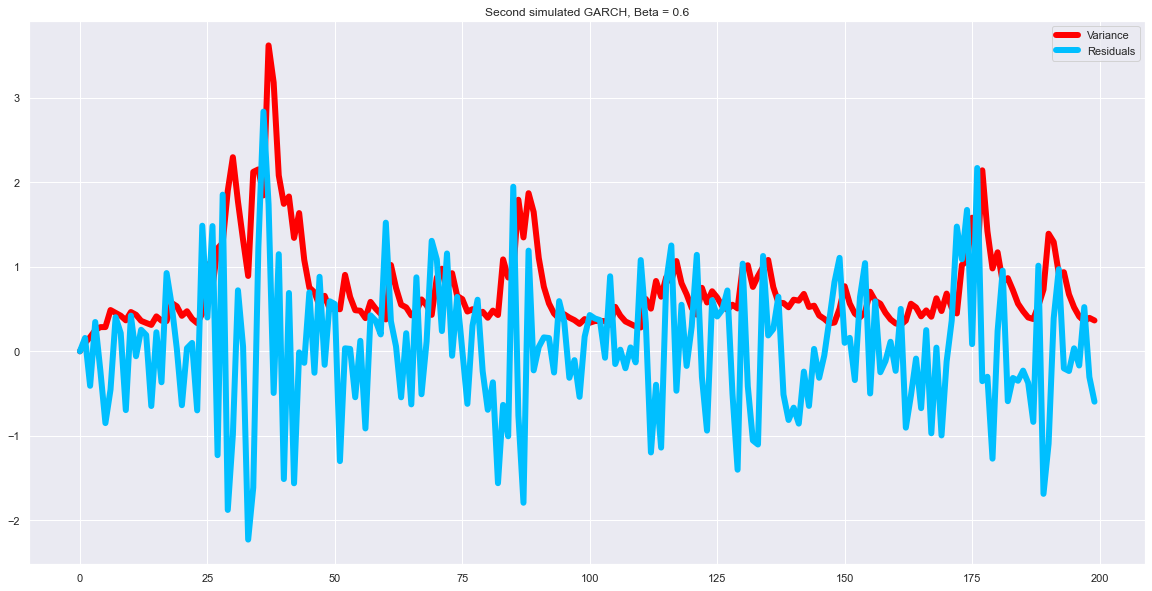

In [33]:

# First simulated GARCH
plt.figure(figsize=(20,10))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance', linewidth = 6)
plt.plot(sim_resid, color = 'green', label = 'Residuals', linewidth = 6)
plt.title('First simulated GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()

# Second simulated GARCH
plt.figure(figsize=(20,10))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance', linewidth = 6)
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals', linewidth = 6)
plt.title('Second simulated GARCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()


# Implementing a basic garch model in python

In [35]:
basicGarch = arch_model(lloyData['logrtn'],
                       p = 1,
                       q = 1,
                       mean = 'constant',
                       vol = 'GARCH',
                       dist = 'normal')
garchResult = basicGarch.fit(update_freq = 4)

Iteration:      4,   Func. Count:     28,   Neg. LLF: 1888.8978691269235
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1888.1962108839516
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1888.1960813040712
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10


In [36]:
print(garchResult.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 logrtn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1888.20
Distribution:                  Normal   AIC:                           3784.39
Method:            Maximum Likelihood   BIC:                           3804.06
                                        No. Observations:                 1010
Date:                Wed, Jun 22 2022   Df Residuals:                     1009
Time:                        15:57:01   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0149  4.240e-02     -0.352      0.725 

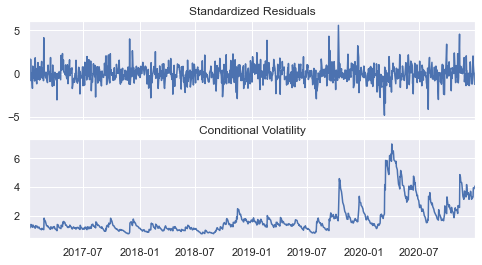

In [41]:
# Plot fitted results
garchResult.plot()
plt.show()

### Making forecasts with garch models

In [45]:
gmForecast = garchResult.forecast(horizon = 5)
print(gmForecast.variance[-1:])

                  h.1        h.2        h.3        h.4       h.5
Date                                                            
2020-12-31  12.887947  12.924605  12.961238  12.997846  13.03443


## Plot the distribution of the standardized residuls since these dont fit normal distribution

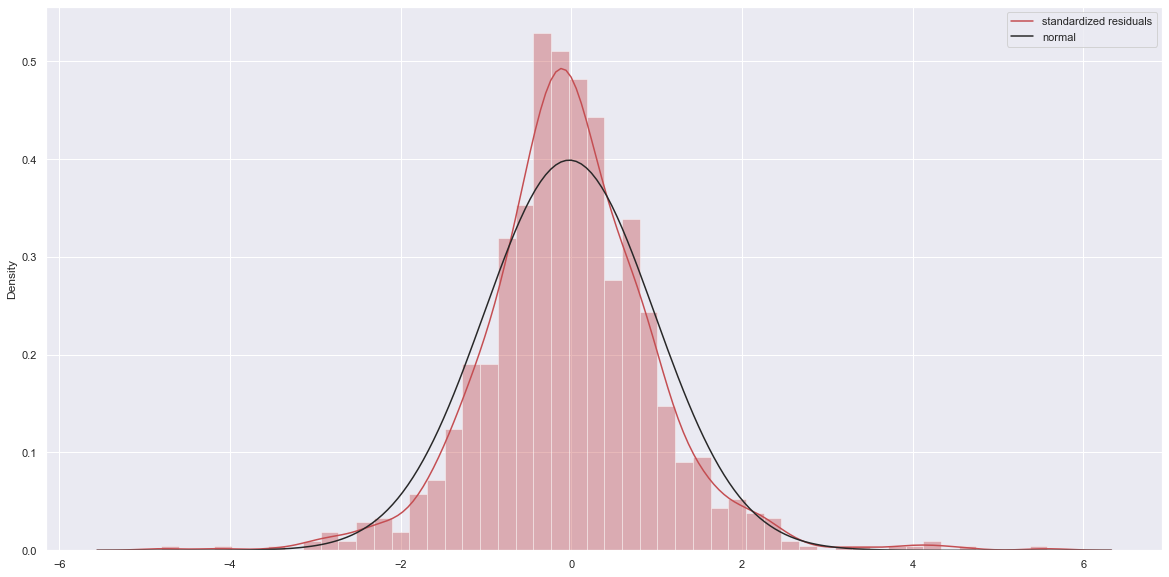

In [59]:
# Obtain model estimated residuals and volatility
garchResid = garchResult.resid
garchStd = garchResult.conditional_volatility

# Calculate the standardized residuals
garchStdResid = garchResid /garchStd

# Plot the histogram of the standardized residuals
plt.figure(figsize=(20,10))
sns.distplot(garchStdResid, color = 'r', fit = stats.norm, bins = 50)
plt.legend(('standardized residuals','normal'))
plt.show()

In [61]:
#Improving the fit with skewed students t 
skewGarch = arch_model(lloyData['logrtn'],
                       p = 1,
                       q = 1,
                       mean = 'constant',
                       vol = 'GARCH',
                       dist = 'skewt')
skewResult = basicGarch.fit(disp = 'off')

skewVol = skewResult.conditional_volatility




In [180]:
normalReturns = lloyData['Return']
skewNormal = arch_model(normalReturns,
                       p = 1,
                       q = 1,
                       mean = 'constant',
                       vol = 'GARCH',
                       dist = 'skewt')
skewResultNormal = skewNormal.fit(disp = 'off')

skewVolNormal = skewResultNormal.conditional_volatility

In [141]:
print(skewVol.pow(2).tail())

Date
2020-12-23    11.061535
2020-12-24    15.610791
2020-12-29    15.618213
2020-12-30    16.730448
2020-12-31    14.609512
Name: cond_vol, dtype: float64


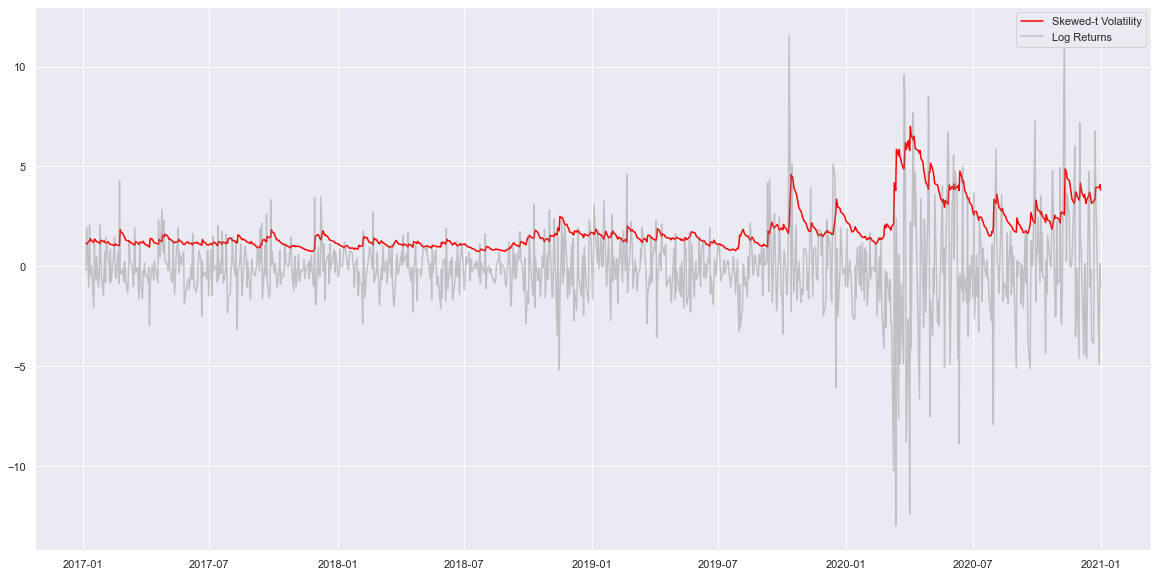

In [63]:
# Plot model fitting results
plt.figure(figsize=(20,10))
plt.plot(skewVol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(lloyData['logrtn'], color = 'grey', 
         label = 'Log Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

## Trying to now identify the mean model for what we want

In [69]:
import pmdarima as pm

model = pm.auto_arima(lloyData['logrtn'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='aic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4293.338, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4294.703, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4291.876, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4291.579, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4293.014, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4293.710, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4292.879, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.346 seconds


In [70]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1010
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -2143.789
Date:                Wed, 22 Jun 2022   AIC                           4291.579
Time:                        16:12:14   BIC                           4301.414
Sample:                             0   HQIC                          4295.315
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0730      0.019      3.763      0.000       0.035       0.111
sigma2         4.0847      0.082     49.572      0.000       3.923       4.246
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [71]:
_arma_model = sm.tsa.SARIMAX(endog = lloyData['logrtn'], order = (0,0,1))
_model_result = _arma_model.fit()

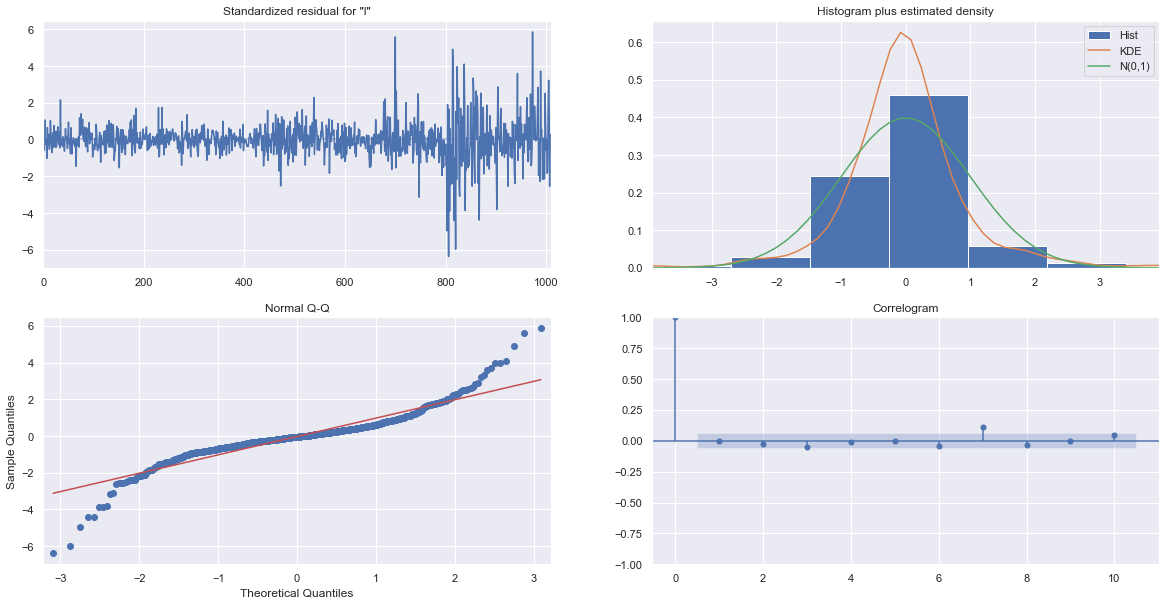

In [72]:
_model_result.plot_diagnostics(figsize=(20, 10))
plt.show()

In [73]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1888.17
Distribution:                  Normal   AIC:                           3782.33
Method:            Maximum Likelihood   BIC:                           3797.08
                                        No. Observations:                 1010
Date:                Wed, Jun 22 2022   Df Residuals:                     1010
Time:                        16:14:01   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0474  4.199e-02      1.129      0.259 [-3.49

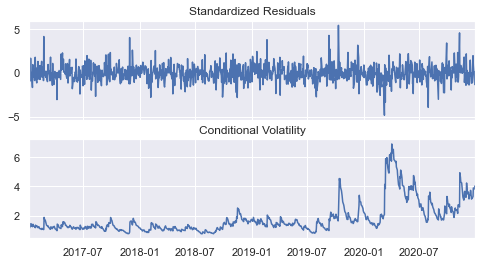

In [74]:
# Plot GARCH model fitted results
_garch_result.plot()
plt.show()

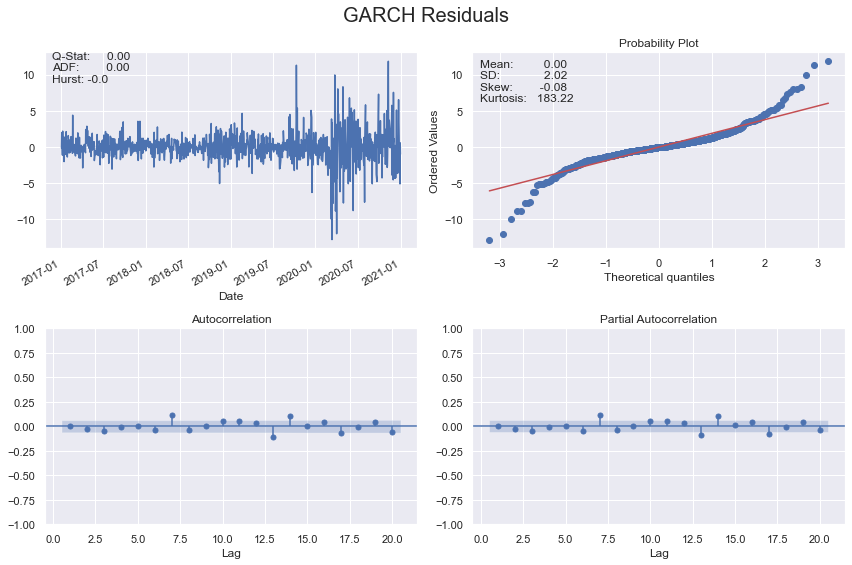

In [76]:
plot_correlogram(_garch_result.resid.dropna(), lags=20, title='GARCH Residuals')

# Rolling Window Forecast

In [86]:
index = lloyData.index
start_loc = 0
end_loc = np.where(index>='2020-01-01')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


In [87]:
index = lloyData.index
start_loc = 0
end_loc = np.where(index >= '2020-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


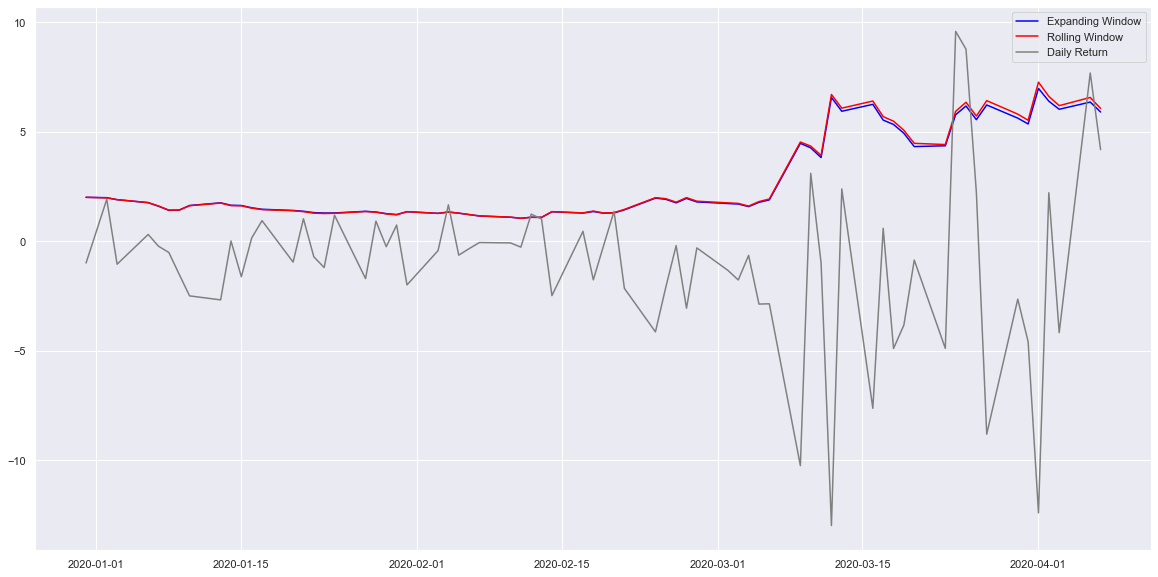

In [89]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)

# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

# Plot results
plt.figure(figsize=(20,10))

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window')

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window')

plt.plot(lloyData.logrtn.loc[variance_expandwin.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()

## BACKTESTING WITH MAE AND MSE
We will practice how to evaluate model performance by conducting backtesting. The out-of-sample forecast accuracy is assessed by calculating MSE and MAE.

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [117]:
def evaluate(observation, forecast, returnType): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)} ({returnType})')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}({returnType})')
    #return mae, mse

In [181]:
#backtest the model with mse 
evaluate(lloyData['logrtn'].sub(lloyData['logrtn'].mean()).pow(2), skewVol**2, 'log')
evaluate(lloyData['Return'].sub(lloyData['Return'].mean()).pow(2), skewVolNormal**2, 'Normal')


Mean Absolute Error (MAE): 4.586 (log)
Mean Squared Error (MSE): 147.883(log)
Mean Absolute Error (MAE): 4.529 (Normal)
Mean Squared Error (MSE): 147.6(Normal)


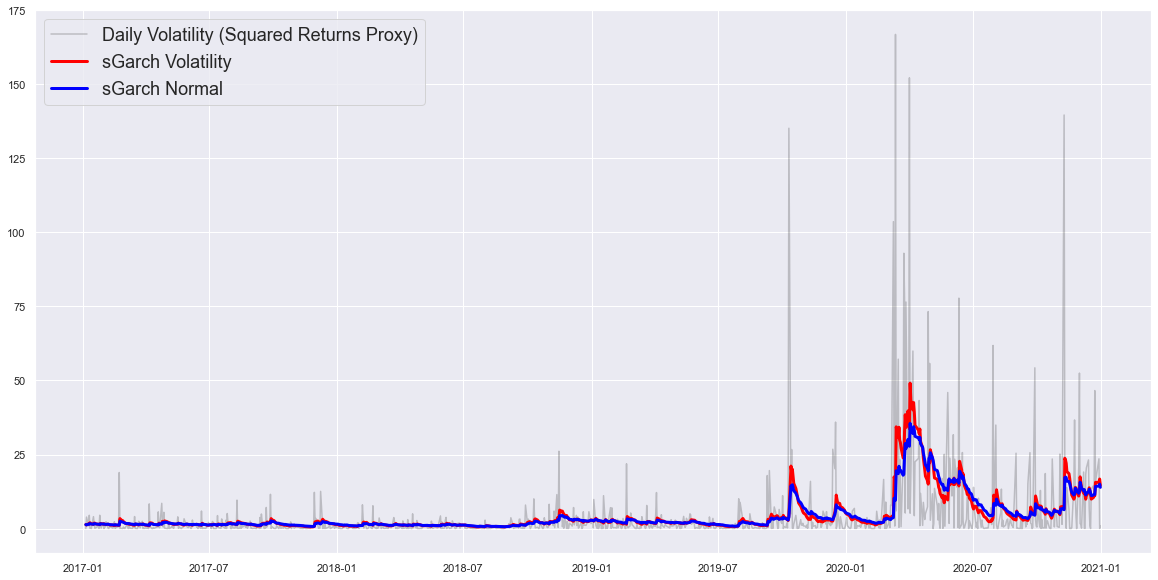

In [182]:
# Plot the actual Proxy Volatility for LLoyds
plt.figure(figsize=(20,10))

plt.plot(lloyData['logrtn'].sub(lloyData['logrtn'].mean()).pow(2), 
         color = 'black', alpha = 0.2, label = 'Daily Volatility (Squared Returns Proxy)')

# Plot sGarch  estimated volatility
plt.plot(skewVol**2, color = 'red', label = 'sGarch Volatility', linewidth = 3)
plt.plot(skewVolNormal**2, color = 'blue', label = 'sGarch Normal', linewidth = 3)

plt.legend(loc = 'best', fontsize = 18)
plt.show()



## Simulating and Boot Strapping

In [143]:
sim_forecasts = skewResult.forecast(horizon=5, method='simulation')
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = skewResult.forecast(horizon=5, method='bootstrap')
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

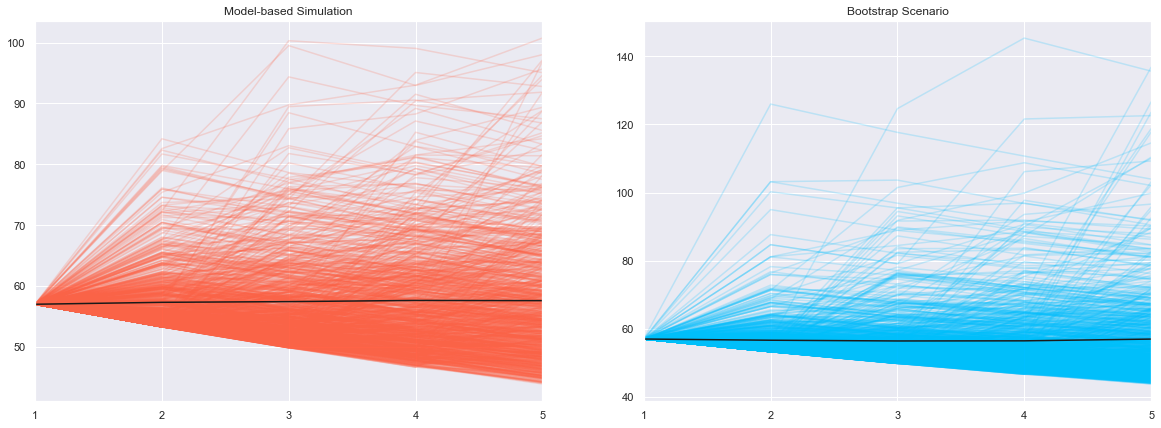

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

x = np.arange(1, 6)

# Plot the paths and the mean, set the axis to have the same limit
axes[0].plot(x, np.sqrt(252 * sim_paths), color='tomato', alpha=0.2)
axes[0].plot(x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)

axes[1].plot(x, np.sqrt(252 * bs_paths), color='deepskyblue', alpha=0.2)
axes[1].plot(x,np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
plt.show()

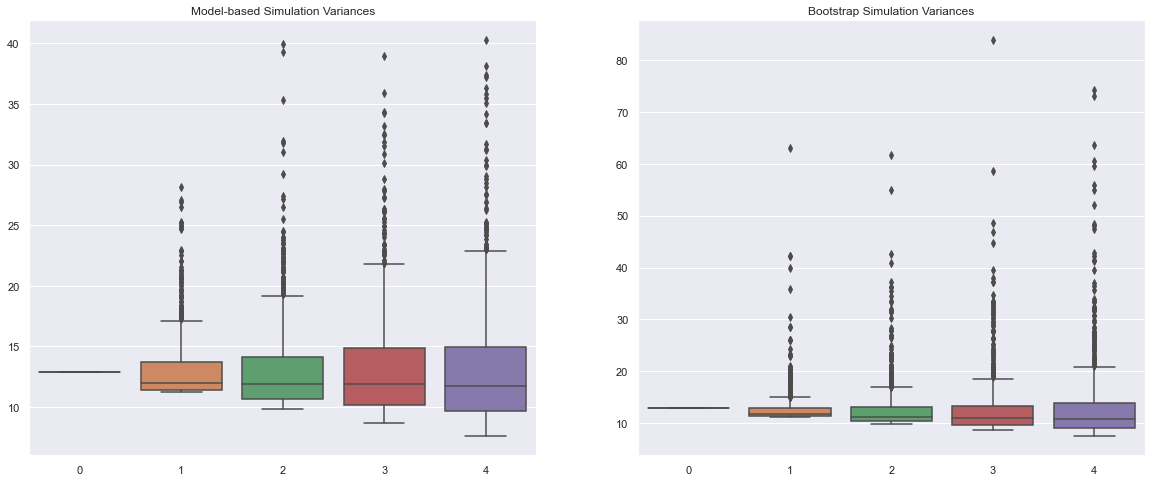

In [150]:
# Plot Simulation Variances
fig, axes = plt.subplots(1, 2, figsize=(20,8))

sns.boxplot(data=sim.variances[-1], ax=axes[0])
sns.boxplot(data=bs.variances[-1], ax=axes[1])

axes[0].set_title('Model-based Simulation Variances')
axes[1].set_title('Bootstrap Simulation Variances')

plt.show()

# Computing VAR for Valentin

In [158]:
am = arch_model(lloyData['logrtn'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')
res = am.fit(disp='off', last_obs='2020-01-01')

In [159]:
forecasts = res.forecast(start='2020-01-01')
cond_mean = forecasts.mean['2020':]
cond_var = forecasts.variance['2020':]
q = am.distribution.ppf([0.01, 0.05], res.params[5])
print(q)

[-2.61580974 -1.55292192]


In [184]:
res.params

mu         -0.056154
omega       0.014485
alpha[1]    0.028566
gamma[1]    0.023212
beta[1]     0.955764
nu          4.790778
Name: params, dtype: float64

In [160]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

,1%,5%
count,254.000000,254.000000
mean,7.944254,4.739065
std,2.635707,1.564734
min,3.953437,2.369845
25%,5.970029,3.567031
50%,7.605788,4.538128
75%,10.163089,6.056315
max,14.300820,8.512753


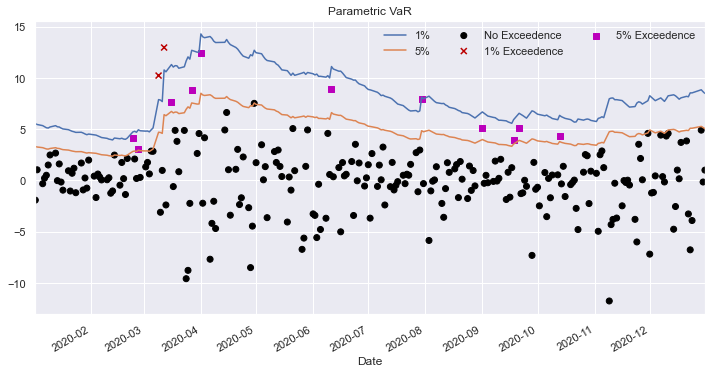

In [163]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets_2020 = lloyData.logrtn['2020':]
rets_2020.name = 'Lloyds Banking Group Log Return'

c = []
for idx in value_at_risk.index:
    if rets_2020[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2020[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')

labels = {
    
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}

markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2020.index[sel],
        -rets_2020.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Parametric VaR')
ax.legend(frameon=False, ncol=3)

plt.show()

# Empirical Value at Risk


In [175]:
# Obtain model estimated residuals and volatility
gm_resid = res.resid
gm_std = res.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Obtain the empirical quantiles
q = gm_std_resid.quantile([.01, .05])
print(q)

0.01   -2.551770
0.05   -1.469271
dtype: float64


In [176]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

,1%,5%
count,254.000000,254.000000
mean,7.751140,4.486810
std,2.571180,1.480446
min,3.858025,2.245213
25%,5.825247,3.377910
50%,7.420960,4.296697
75%,9.915654,5.733104
max,13.952085,8.057220


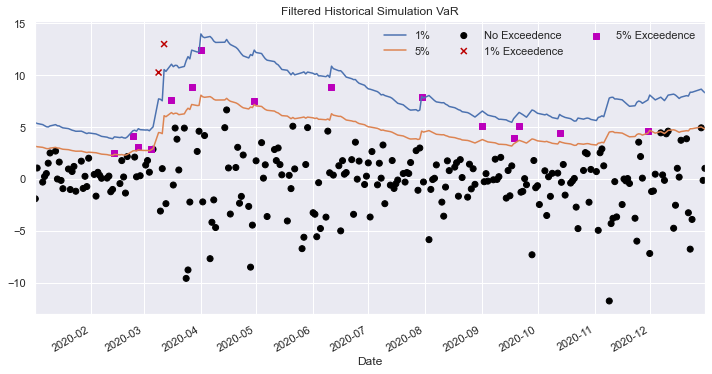

In [177]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets_2020 = lloyData.logrtn['2020':]
rets_2020.name = 'Lloyds Banking Group Log Return'

c = []
for idx in value_at_risk.index:
    if rets_2020[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2020[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2020.index[sel],
        -rets_2020.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Filtered Historical Simulation VaR')
ax.legend(frameon=False, ncol=3)

plt.show()

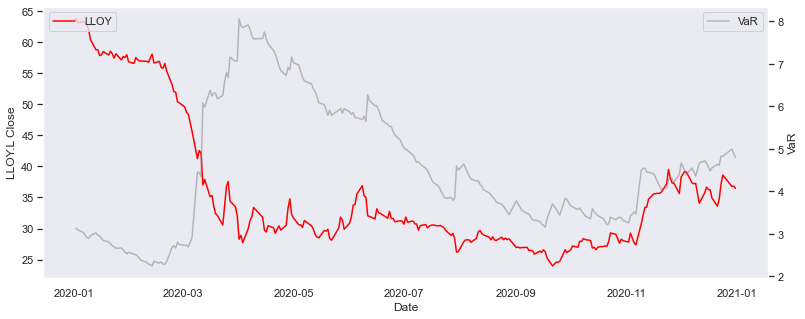

In [179]:
fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()

ax1.grid(False)
ax2.grid(False)

ax1.plot(lloyData.loc[value_at_risk.index[0]:].index, lloyData.loc[value_at_risk.index[0]:].Close, 
         color='red', label='LLOY')
ax2.plot(value_at_risk['5%'].index, value_at_risk['5%'], color='grey', label='VaR', alpha=0.5)

ax1.set_xlabel('Date')
ax1.set_ylabel('LLOY.L Close')
ax2.set_ylabel('VaR')

ax1.legend(loc='upper left')
ax2.legend()

plt.show()